In [180]:
import pandas as pd
import datetime
import numpy as np

#fields = ['timestamp', 'replies','likes', 'retweets' ,'text']
# clean_tweets_part_2.csv #Contains data from 2015-11-03 to 2017-02-17
filename = 'gs://bigdata-general/clean/clean_tweets_part_0.csv'

tweets = pd.read_csv(filename, delimiter=',', index_col=0, nrows=1000000)
# Convert timestamp to date object
tweets['timestamp'] = pd.to_datetime(tweets['timestamp']).dt.date
tweets

,timestamp,replies,likes,retweets,text
0,2019-05-27,0,0,0,È appena uscito un nuovo video! LES CRYPTOMONNAIES QUI PULVÉRISENT BITCOIN EN 2019 https://t.co/...
1,2019-05-27,0,0,0,Cardano: Digitize Currencies; EOS https://t.co/1kTKqKEBlS 6500% ROI; AT&amp;T Bitcoin Bill Pay h...
2,2019-05-27,0,2,1,Another Test tweet that wasn't caught in the stream ! bitcoin
3,2019-05-27,0,0,0,Current Crypto Prices! \n\nBTC: $8721.99 USD\nETH: $266.62 USD\nLTC: $114.03 USD\nBCH: $432.02 U...
4,2019-05-27,0,0,0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NOT A Currency.\n\nhttps://t.co/FJru1ooxSM\n\nhttps:...
...,...,...,...,...,...
999995,2019-05-21,0,0,0,Dutch Man Arrested Over $2.2 Million Bitcoin Mining Fraud https://t.co/1Ojr3wownq https://t.co/j...
999996,2019-05-21,2,35,21,This is how crypto can do some of it's best work. For Apollo Currency to partner with this organ...
999997,2019-05-21,0,0,0,クレイグ・ライト氏、\nBitcoinホワイトペーパー\n著作権を登録 ✍️\n💸BSV高騰したようで\n\nでも、過去のニュースを振り返ると\nなんか素直に受けとめれないっつーか\nうーむ🤔...
999998,2019-05-21,0,0,0,Bitcoin doesn't have inherent value. \nAltcoins inherently don't have value.


# Cleaning Tweets V2

In [181]:
#nltk.download('stopwords')
#nltk.download('words')
import nltk 
import string
import re

more_stopwords = [ 'technology','https', 'blockchain', 'btc', 't', 'co', 'eth', 'usd', 'doge', 'bitcoin', 'ethereum', 'buy', 'usd', 'xrp', 'ltc', 'crypto', 'price', 'will', 'mxn', 'think', 'take', 'one', 'xlm', 'cann', 'said', 'blockchaintechnology','alt','coin', 'bch', 'neo', 'emc' ,'xmr' ,'btg' ,'hot', 'usc' ,'ooobtc', 'obx' ,'qkc', 'bch' ,'gt' ,'lt', 'at', 'price']
stopword = nltk.corpus.stopwords.words('english')
stopword.extend(more_stopwords)
words = set(nltk.corpus.words.words())

def clean_tweet(text):
    ps = nltk.PorterStemmer()
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text.lower()) #Remove http links
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+',' ', text) #Remove non-ASCII characters
    text = " ".join([word for word in text.split() if word not in stopword])
    text = " ".join([ps.stem(word) for word in text.split()])
    text = " ".join(w for w in nltk.wordpunct_tokenize(text) \
         if w.lower() in words or not w.isalpha())
    return text

tweets['text'] = tweets['text'].apply(lambda x: clean_tweet(x.lower()))
# # Removing empty tweets
tweets = tweets[~tweets.text.eq('')]

In [182]:
# thestring = "text1\ntext2\nhttp://url.com/bla1/blah1/\ntext3\ntext4\nhttp://url.com/bla2/blah2/\ntext5\ntext6"
# clean_s = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", thestring)
# #print(clean_s)
# clean_tweet(thestring)

In [183]:
# bad_tweet = thestring + ' ' + tweets.iloc[8].text + ' ' + tweets.iloc[13].text + ' ' + tweets.iloc[20].text + ' ' +tweets.iloc[3].text + ' ' +tweets.iloc[48].text # Bad Tweet
# print("BAD TWEET: ", bad_tweet)
# clean_t = clean_tweet(bad_tweet)
# print("CLEAN TWEET: ", clean_t)


# Labeling Cleaned tweets

In [184]:
# Sort dataframe set by timestamp and reindex
#
tweets = tweets.sort_values(by=['timestamp'])
tweets = tweets.reset_index(drop=True)
tweets.tail()

,timestamp,replies,likes,retweets,text
838133,2019-05-27,0,0,0,worth nan nan
838134,2019-05-27,0,0,0,abduct murder rise via address
838135,2019-05-27,0,0,0,el de la overwatch part para lo pico
838136,2019-05-27,0,1,1,digit
838137,2019-05-27,0,0,0,un video en


In [186]:
# Load historical bitcoin data from the following file located in gs://bigdata-general/bitcoin_historical_price.csv
# Parse date column as a date

bitcoin = pd.read_csv("gs://bigdata-general/bitcoin_historical_price.csv", index_col=0, parse_dates=True)

In [187]:
# Remove time from Date
bitcoin['Date'] = pd.to_datetime(bitcoin['Date']).dt.date

In [188]:
# calculate daily percentage change from opening to close.
daily_change = (bitcoin['Close'] - bitcoin['Open'])/bitcoin['Open']*100
# Label daily_change depending on the following conditions:
#     if daily_change is less than -10, label it as 0
#     if daily_change is in range -10 to -3, label it as 1
#     if daily_change is in range -3 to 3, label it as 2
#     if daily_change is in range 3 to 10, label it as 3
#     if daily_change is greater than 10, label it as 4

# create a new column in the dataframe
bitcoin['%Daily Chg'] = daily_change
bitcoin['label'] = np.where(daily_change < -10, 0,
                   np.where(daily_change < -3, 1,
                   np.where(daily_change < 3, 2,
                   np.where(daily_change < 10, 3, 4))))

#bitcoin

                    

In [189]:
#bitcoin[bitcoin.label == 4]

In [190]:
labeled = []
labeled = pd.DataFrame(labeled)
labeled['Date'] = bitcoin['Date']
labeled['Daily %Chg'] = daily_change
labeled['Cat.'] = bitcoin['label']
labeled = labeled.reset_index(drop=True)
#labeled

## Create a dictionary of historical bitcoin price changes by dat from lists

In [191]:
from dateutil import parser

dates = labeled.Date.values
categories = labeled['Cat.'].values

# Create a dictionary with dates as keys and categories as values
date_cat_dict = dict(zip(dates, categories))

# Create a list of dates
date = parser.parse('2021-06-28').date()
print(date_cat_dict[date])

2


## Add Category label to each Tweet

In [192]:
tweets['Date'] = tweets.timestamp.rename('Date')
# Drop column timestamp from tweets
tweets = tweets.drop(columns=['timestamp'])

In [74]:
# Set value of column 'Category' if 'Date' matches the given date
# #
# date = parser.parse('2011-01-09').date()
# # Change 'Category' column values to 3 if 'Date' matches the given date
# tweets[tweets['Date'] == date]['Category'].values[0] = 3

# # Replace values based on conditions 
# # https://kanoki.org/2019/07/17/pandas-how-to-replace-values-based-on-conditions/
# tweets.loc[(tweets.Date == date), 'Category'] = 2

# # Print the number of tweets labeled as '3'
# print(tweets['Category'].value_counts())


In [193]:
# Match the timestamp of the tweets with bitcoin price and add a category label to the tweets
for key, value in date_cat_dict.items():
    tweets.loc[(tweets['Date'] == key), 'Category'] = value

In [194]:
 # Drop rows with missing Category value
 tweets = tweets[tweets['Category'].notnull()]
 tweets = tweets.reset_index(drop=True)
 tweets

,replies,likes,retweets,text,Date,Category
0,3,15,8,rapper say lot remix,2013-05-11,2.0
1,2,4,6,add panic panic sell button,2013-05-14,1.0
2,1,0,9,rumor weekend san huge sting arrest pass also attend,2013-05-15,2.0
3,2,15,22,peter get bug,2013-05-16,3.0
4,1,4,9,stand room state address,2013-05-18,2.0
...,...,...,...,...,...,...
838072,0,0,0,worth nan nan,2019-05-27,2.0
838073,0,0,0,abduct murder rise via address,2019-05-27,2.0
838074,0,0,0,el de la overwatch part para lo pico,2019-05-27,2.0
838075,0,1,1,digit,2019-05-27,2.0


In [195]:
tweets[tweets.Category == 3]

,replies,likes,retweets,text,Date,Category
3,2,15,22,peter get bug,2013-05-16,3.0
18,2,0,0,sure wait,2013-10-03,3.0
19,1,1,0,whoa,2013-11-06,3.0
28,0,0,0,vale r e es de se es de r,2013-11-29,3.0
37,0,3,0,back thousand last check,2014-01-05,3.0
...,...,...,...,...,...,...
831870,2,7,2,your live legend,2019-05-26,3.0
831871,1,99,84,bu en n z block lar,2019-05-26,3.0
831872,7,60,8,save money get free use life ye margarita click link pin tweet start save money get free life,2019-05-26,3.0
831873,14,436,196,muller new watch also wallet,2019-05-26,3.0


In [196]:
#clean_tweets_part_0.csv
tweets.to_csv('/home/amaru-razerblade/clean_text_tweets/clean_text_tweets_part_0.csv')

In [197]:
!cd '/home/amaru-razerblade/clean_text_tweets' && gsutil cp clean_text_tweets_part_0.csv gs://bigdata-general/clean_text/clean_text_tweets_part_0.csv

Copying file://clean_text_tweets_part_0.csv [Content-Type=text/csv]...

Operation completed over 1 objects/48.5 MiB.                                     


# Util functions

In [ ]:
time = tweets['timestamp'][0]
# convert string to date object
time = datetime.datetime.strptime(time, '%Y-%m-%d').date()
# conver time to date
labeled['Date'].values[0]
time

In [102]:
d = '2013-04-29'
# convert d to a datetime object
d = datetime.datetime.strptime(d, '%Y-%m-%d').date()

val = labeled.loc[labeled.Date == r_date]['Cat.'].values[0]
val

2

# Old Cleaning

In [2]:
import string
import re
import emoji
import nltk
from stop_words import get_stop_words
nltk.download('words')
words = set(nltk.corpus.words.words())

def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet) #Remove non-ASCII characters
    #tweet = re.sub(r'[^\w]', ' ', tweet) #Remove Symbols and punctuation
    tweet  = "".join([char for char in tweet if char not in string.punctuation]) #Remove punctuation
    tweet = re.sub('[0-9]+', '', tweet) # Remove numbers
    # Remove stop words
    tweet = " ".join([word for word in tweet.split() if word not in (get_stop_words('english'))])
    tweet = " ".join(tweet.split())
    #tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha())
    return tweet


[nltk_data] Downloading package words to /home/amaru-
[nltk_data]     razerblade/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [63]:
tweets['text'] = tweets['text'].map(lambda x: cleaner(x))

In [64]:
# # Removing empty tweets
tweets = tweets[~tweets.text.eq('')]


In [ ]:
tweets.reset_index(drop=True)

# Cleaning with Lemmatization of words
https://www.kaggle.com/ragnisah/text-data-cleaning-tweets-analysis

In [21]:
nltk.download('stopwords')
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)


[nltk_data] Downloading package stopwords to /home/amaru-
[nltk_data]     razerblade/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Text(0.5, 1.0, 'All Tweets')

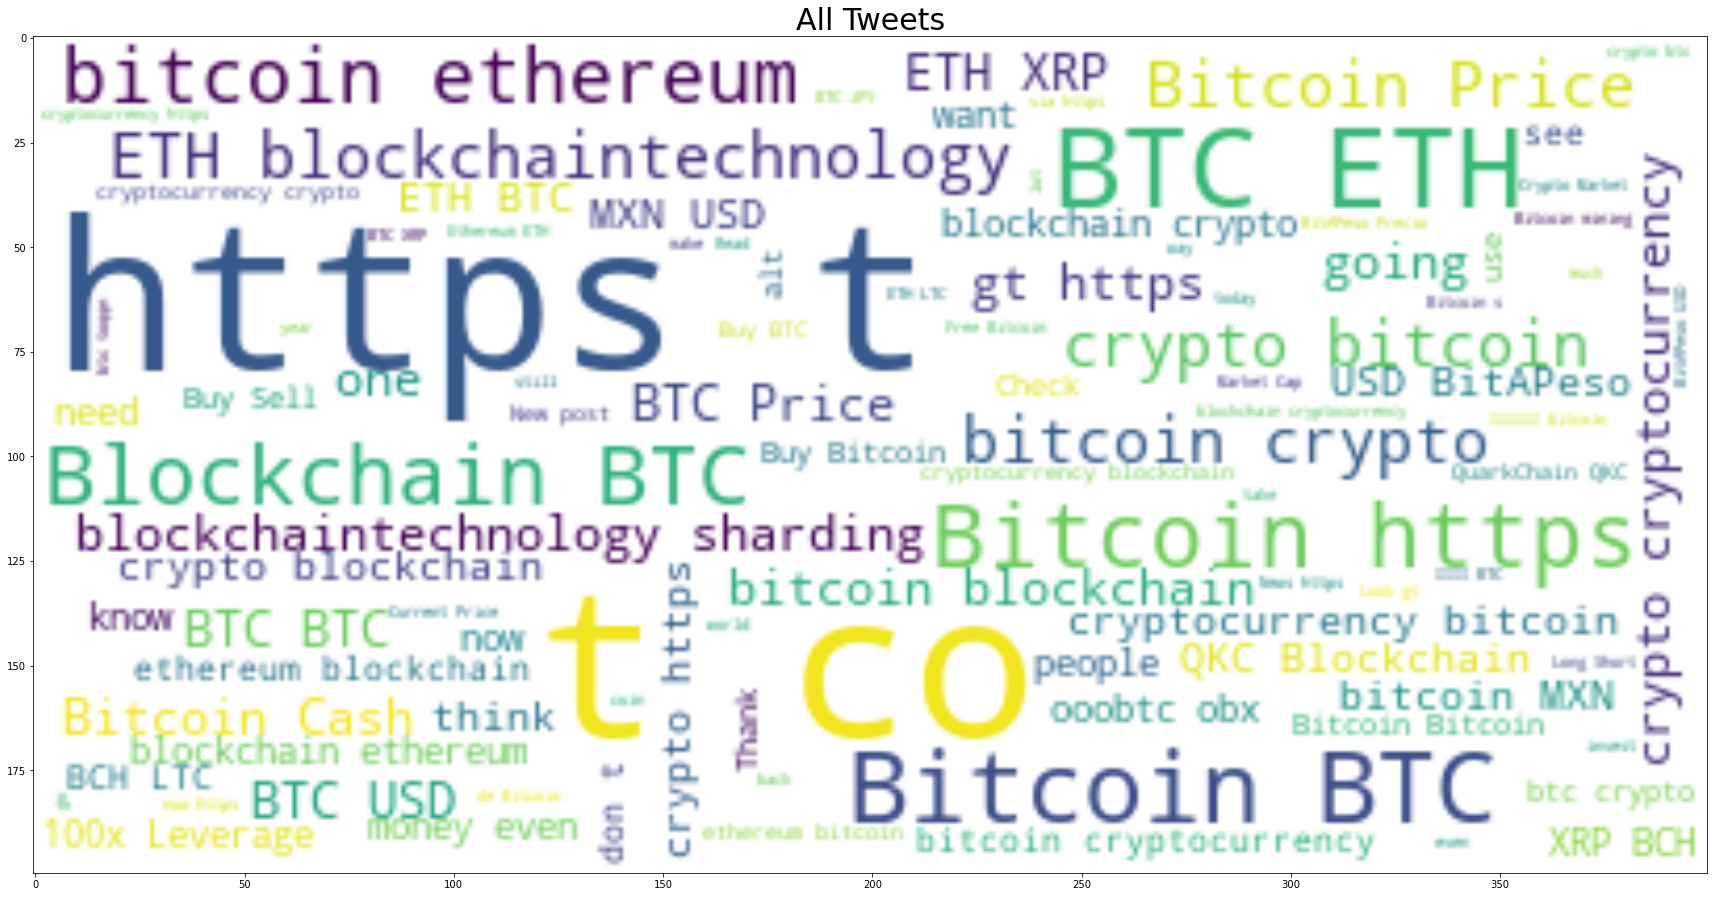

In [14]:
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
tweet_All = " ".join(review for review in tweets.text)
fig, ax = plt.subplots(1, 1, figsize  = (30,30))
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)
ax.imshow(wordcloud_ALL, interpolation='bilinear')
ax.set_title('All Tweets', fontsize=30)

In [123]:
more_stopwords = [ 'technology','https', 'blockchain', 'btc', 't', 'co', 'eth', 'usd', 'doge', 'bitcoin', 'ethereum', 'buy', 'usd', 'xrp', 'ltc', 'crypto', 'price', 'will', 'mxn', 'think', 'take', 'one', 'xlm', 'cann', 'said', 'blockchaintechnology','alt','coin', 'bch', 'neo', 'emc' ,'xmr' ,'btg' ,'hot', 'usc' ,'ooobtc', 'obx' ,'qkc', 'bch' ,'gt' ,'lt', 'at']

In [124]:
stopword = nltk.corpus.stopwords.words('english')
stopword.extend(more_stopwords)
